# Basic feed-forward ANN Model

**In this exercise, you will use an ANN to predict stock prices and returns, i.e. a regression task. In most cases, all data is the same, but here you need to isolate the univariate time series and standardize. Standardization is essential with stock data, in order to avoid any in-depth and unnecessary mathematical details under-the-hood. It tends to help more than not.**

**It is best to standardize the data before creating the 'supervised' datasets for forecasting, i.e. before creating *X* and *Y* variables for one-step, incremental multi-step and multi-output multi-step forecasting. You can un-standardize the predictions when comparing to the actual values.**

**NOTE: Ensure stationarity in time series before standardization or modeling.**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model

np.random.seed(123)

tf.random.set_seed(123)

%matplotlib inline

In [2]:
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler

In [3]:
df0 = pd.read_csv('data/sp500sub.csv', index_col='Date', parse_dates=True)

In [4]:
# Starbucks Close prices

df = df0[df0['Name'] == 'SBUX'][['Close']].copy()

In [5]:
df['LogClose'] = np.log(df['Close'])

In [6]:
df['DiffLogClose'] = df['LogClose'].diff()

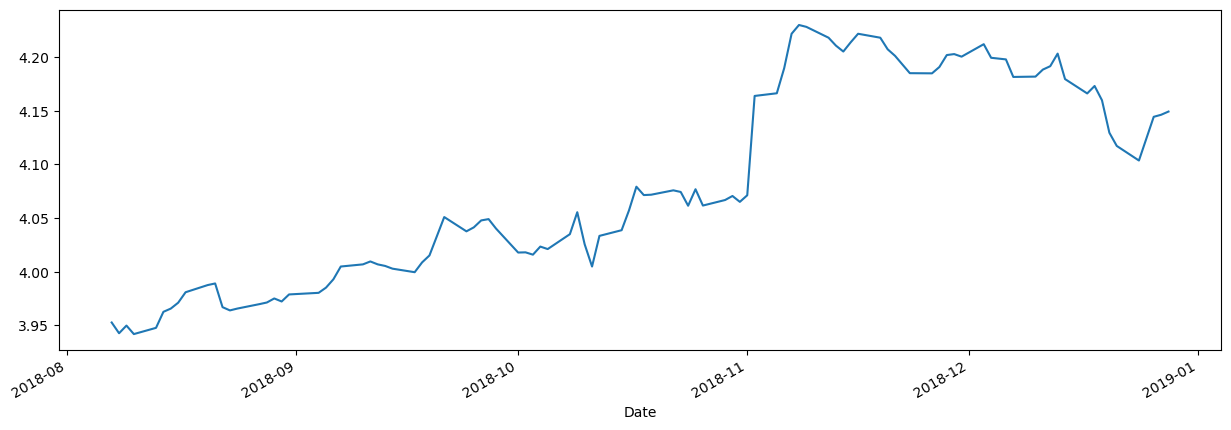

In [7]:
df['LogClose'][-100:].plot(figsize=(15, 5));

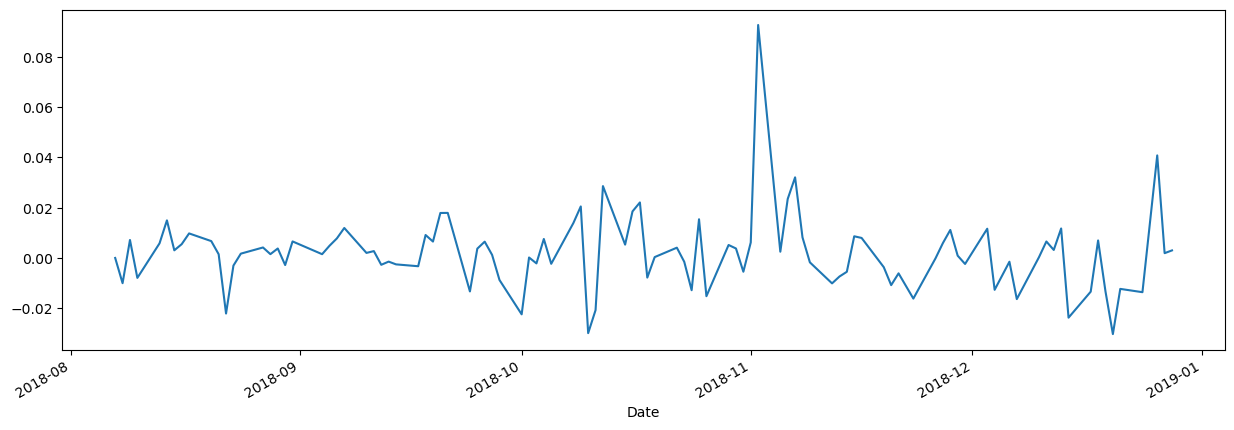

In [8]:
df['DiffLogClose'][-100:].plot(figsize=(15, 5));

**The log-transformed plot resembles the original data, whereas the 'differenced' data is completely... different! In order to compare predictions to the true values, you need to 'un-difference' the data before forecasting (after training the model).**

## Standardize time series

**You are standardizing the stationary time series, i.e. the 'differenced' data.**

In [9]:
Ntest = 21

train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]

In [10]:
scaler = StandardScaler()

train_scaled = scaler.fit_transform(train[['DiffLogClose']])

test_scaled = scaler.transform(test[['DiffLogClose']])

In [11]:
# Boolean series to index df rows

train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

In [12]:
# Add flattened standardized values to df

df.loc[train_idx, 'ScaledLogReturn'] = train_scaled.flatten()

df.loc[test_idx, 'ScaledLogReturn'] = test_scaled.flatten()

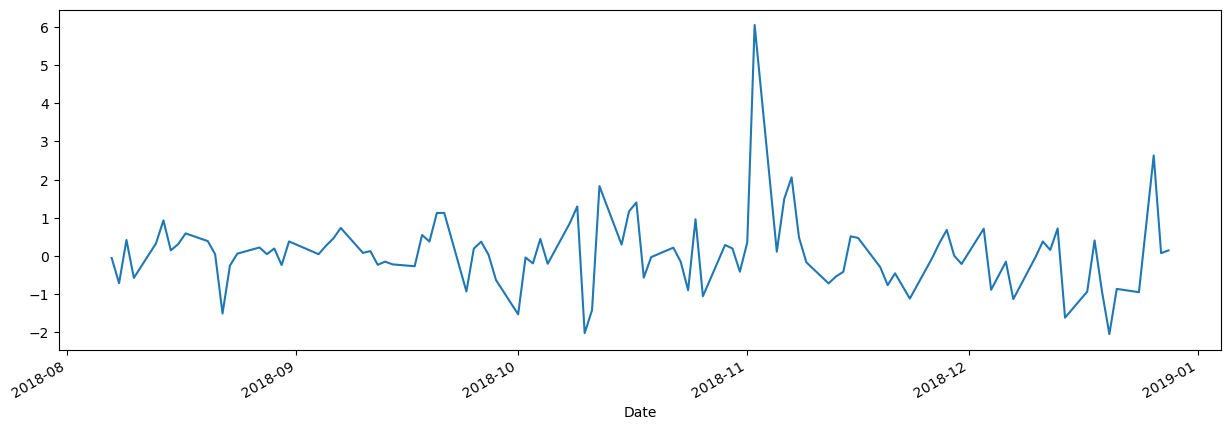

In [13]:
df['ScaledLogReturn'][-100:].plot(figsize=(15, 5));

## Make 'supervised' dataset

**Create X and Y data for one-step and multi-step forecasting.**

In [15]:
series = df['ScaledLogReturn'].dropna().to_numpy()

# 10 past lags to predict value in Y
T = 10

X = []
Y = []

for t in range(len(series) - T):
    x = series[t:t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)

X = np.array(X).reshape(-1, T)
Y = np.array(Y)

N = len(X)

print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (2252, 10) Y.shape (2252,)


In [16]:
# Split X and Y into X_train, y_train, X_test, y_test

X_train, y_train = X[:-Ntest], Y[:-Ntest]

X_test, y_test = X[-Ntest:], Y[-Ntest:]

## Build basic ANN regression model

**For one-step and incremental multi-step forecasting:**

In [17]:
i = Input(shape=(T,))

x = Dense(32, activation='relu')(i)

x = Dense(1)(x)

model = Model(i, x)

In [18]:
# Choose optimization methods

model.compile(loss='mse', optimizer='adam')

In [19]:
# Train model

r = model.fit(X_train, 
              y_train, 
              epochs=200, 
              validation_data=(X_test, y_test))

Epoch 1/200
70/70 [==============================] - 1s 3ms/step - loss: 1.3127 - val_loss: 1.3047
Epoch 2/200
70/70 [==============================] - 0s 2ms/step - loss: 1.1276 - val_loss: 1.2156
Epoch 3/200
70/70 [==============================] - 0s 1ms/step - loss: 1.0713 - val_loss: 1.1812
Epoch 4/200
70/70 [==============================] - 0s 2ms/step - loss: 1.0449 - val_loss: 1.1674
Epoch 5/200
70/70 [==============================] - 0s 1ms/step - loss: 1.0318 - val_loss: 1.1476
Epoch 6/200
70/70 [==============================] - 0s 1ms/step - loss: 1.0201 - val_loss: 1.1260
Epoch 7/200
70/70 [==============================] - 0s 1ms/step - loss: 1.0101 - val_loss: 1.1253
Epoch 8/200
70/70 [==============================] - 0s 1ms/step - loss: 1.0013 - val_loss: 1.0972
Epoch 9/200
70/70 [==============================] - 0s 1ms/step - loss: 0.9940 - val_loss: 1.1083
Epoch 10/200
70/70 [==============================] - 0s 1ms/step - loss: 0.9895 - val_loss: 1.0978
Epoch 11/

70/70 [==============================] - 0s 1ms/step - loss: 0.8766 - val_loss: 0.9932
Epoch 84/200
70/70 [==============================] - 0s 1ms/step - loss: 0.8740 - val_loss: 1.0172
Epoch 85/200
70/70 [==============================] - 0s 1ms/step - loss: 0.8757 - val_loss: 0.9920
Epoch 86/200
70/70 [==============================] - 0s 1ms/step - loss: 0.8738 - val_loss: 1.0209
Epoch 87/200
70/70 [==============================] - 0s 1ms/step - loss: 0.8752 - val_loss: 1.0052
Epoch 88/200
70/70 [==============================] - 0s 1ms/step - loss: 0.8713 - val_loss: 1.0026
Epoch 89/200
70/70 [==============================] - 0s 1ms/step - loss: 0.8704 - val_loss: 0.9988
Epoch 90/200
70/70 [==============================] - 0s 1ms/step - loss: 0.8724 - val_loss: 1.0194
Epoch 91/200
70/70 [==============================] - 0s 1ms/step - loss: 0.8696 - val_loss: 1.0549
Epoch 92/200
70/70 [==============================] - 0s 1ms/step - loss: 0.8701 - val_loss: 1.0146
Epoch 93/200


70/70 [==============================] - 0s 1ms/step - loss: 0.8195 - val_loss: 1.0058
Epoch 165/200
70/70 [==============================] - 0s 2ms/step - loss: 0.8192 - val_loss: 1.0476
Epoch 166/200
70/70 [==============================] - 0s 2ms/step - loss: 0.8197 - val_loss: 1.0107
Epoch 167/200
70/70 [==============================] - 0s 1ms/step - loss: 0.8216 - val_loss: 0.9888
Epoch 168/200
70/70 [==============================] - 0s 1ms/step - loss: 0.8180 - val_loss: 1.0137
Epoch 169/200
70/70 [==============================] - 0s 2ms/step - loss: 0.8171 - val_loss: 1.0054
Epoch 170/200
70/70 [==============================] - 0s 1ms/step - loss: 0.8174 - val_loss: 1.0018
Epoch 171/200
70/70 [==============================] - 0s 1ms/step - loss: 0.8168 - val_loss: 1.0002
Epoch 172/200
70/70 [==============================] - 0s 2ms/step - loss: 0.8178 - val_loss: 1.0351
Epoch 173/200
70/70 [==============================] - 0s 1ms/step - loss: 0.8148 - val_loss: 0.9902
Epoc

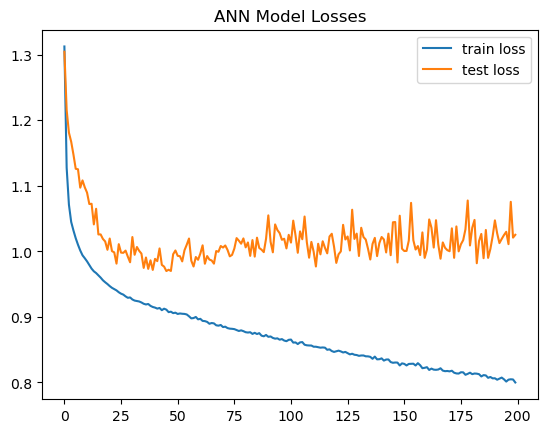

In [20]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.title("ANN Model Losses")
plt.legend();

**The test loss behaves irratically which indicates overfitting.**

### One-step Forecast

In [21]:
# Remember first T + 1 values are not predictable

train_idx[:T+1] = False 

In [22]:
# Predictions for diffed data

P_train = model.predict(X_train)

P_test = model.predict(X_test)

1/1 [==============================] - 0s 20ms/step


In [23]:
# Unstandardize predictions (invert scaling)

P_train = scaler.inverse_transform(P_train).flatten()

P_test = scaler.inverse_transform(P_test).flatten()

In [24]:
# Store diffed predictions (unstandardized)

df.loc[train_idx, 'Diff ANN Train Prediction'] = P_train

df.loc[test_idx, 'Diff ANN Test Prediction'] = P_test

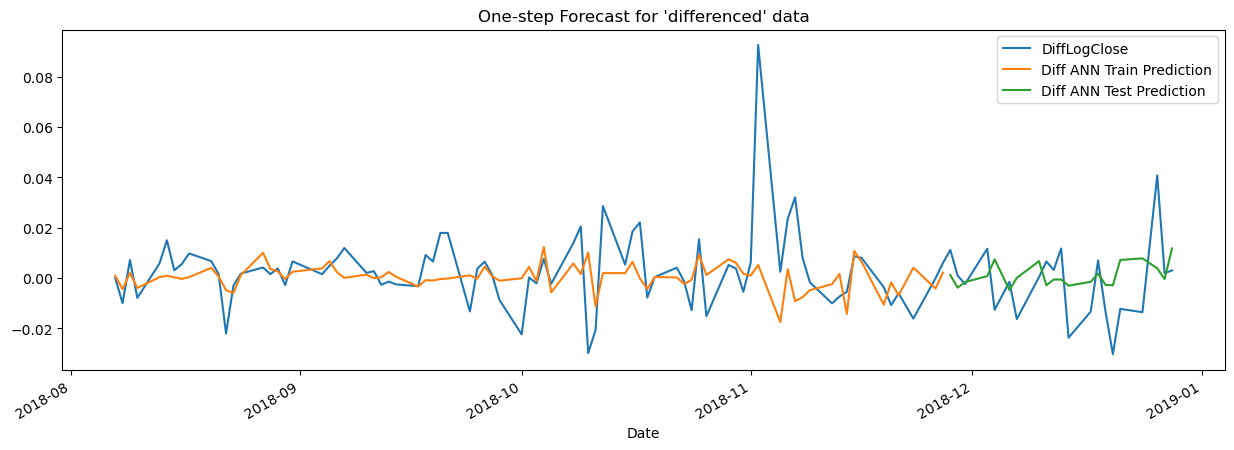

In [26]:
cols = ['DiffLogClose', 'Diff ANN Train Prediction', 'Diff ANN Test Prediction']

df[cols][-100:].plot(figsize=(15, 5))
plt.title("One-step Forecast for 'differenced' data");

**The one-step forecast is not that bad, as it has picked up on the direction but not the magnitude of the values.**

In [27]:
# Compute un-differenced predictions

df['ShiftLogClose'] = df['LogClose'].shift(1)

prev = df['ShiftLogClose']

In [28]:
# Obtain last-known training value in un-differenced data (don't need yet)

last_train = train.iloc[-1]['LogClose']

In [29]:
# One-step forecast

df.loc[train_idx, 'onestep_train'] = prev[train_idx] + P_train

df.loc[test_idx, 'onestep_test'] = prev[test_idx] + P_test

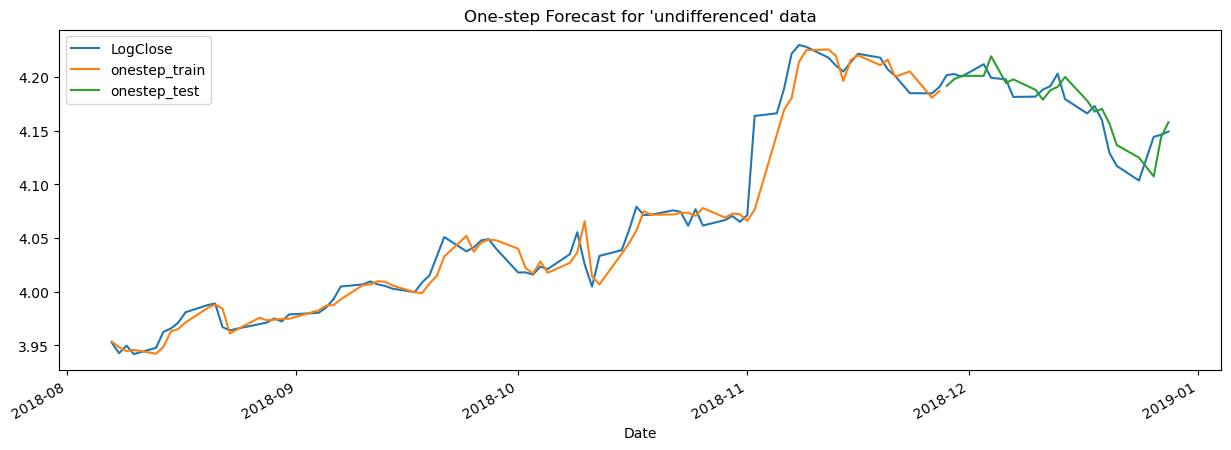

In [30]:
df.iloc[-100:][['LogClose', 'onestep_train', 'onestep_test']].plot(figsize=(15, 5))
plt.title("One-step Forecast for 'undifferenced' data");

**This looks pretty good, but this just lags the preivous value, which is expected as it is one-step forecast.**

### Incremental Multi-step Forecast

In [31]:
multistep_predictions = []

# First test set input
last_x = X_test[0]

while len(multistep_predictions) < Ntest:
    p = model.predict(last_x.reshape(1, -1))[0]
    
    # Update the predictions list
    multistep_predictions.append(p)
    
    # Make the new input
    last_x = np.roll(last_x, -1)
    last_x[-1] = p

1/1 [==============================] - 0s 19ms/step


In [32]:
# Unscale predictions

multistep_predictions = np.array(multistep_predictions)

multistep_predictions = scaler.inverse_transform(multistep_predictions.reshape(-1, 1)).flatten()

In [33]:
# Save multi-step forecast to df

df.loc[test_idx, 'multistep'] = last_train + np.cumsum(multistep_predictions)

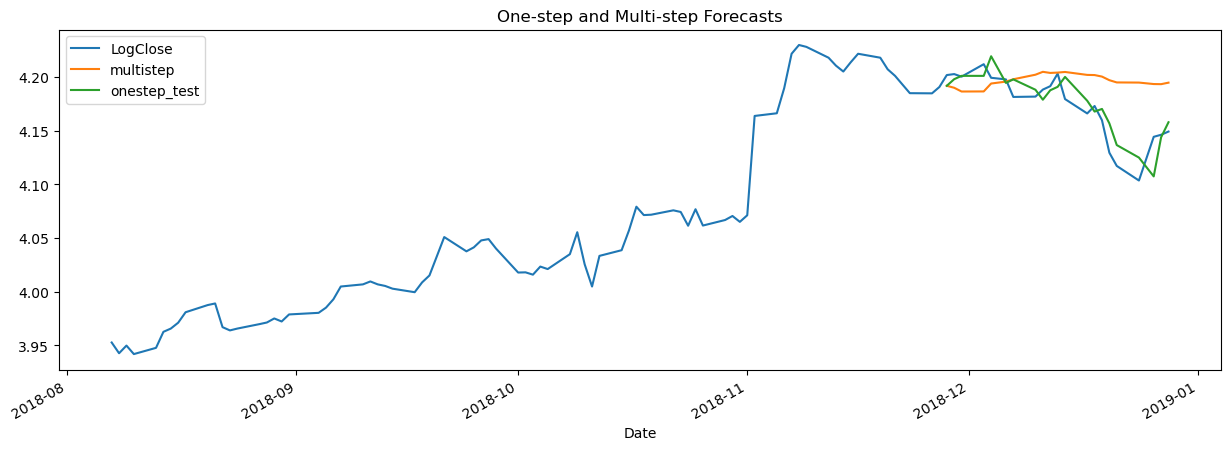

In [35]:
df.iloc[-100:][['LogClose', 'multistep', 'onestep_test']].plot(figsize=(15, 5))
plt.title("One-step and Multi-step Forecasts");

**The incremental multi-step forecasts are worse, being just a straight line with a slight trend.**

### Multi-output Multi-step Forecast

In [36]:
# Make multi-output supervised dataset

Tx = T
Ty = Ntest
X = []
Y = []

for t in range(len(series) - Tx - Ty + 1):
    x = series[t:t+Tx]
    X.append(x)
    y = series[t+Tx:t+Tx+Ty]
    Y.append(y)

# Convert to NumPy
X = np.array(X).reshape(-1, Tx)
Y = np.array(Y).reshape(-1, Ty)

N = len(X)

print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (2232, 10) Y.shape (2232, 21)


In [37]:
# Split X and Y into Xtrain, Ytrain, Xtest, Ytest

Xtrain, Ytrain = X[:-1], Y[:-1]

Xtest, Ytest = X[-1:], Y[-1:]

#### Re-build ANN model

**Make sure to edit the number of outputs in the final layer, to match the number of timesteps to forecast for in the future.**

In [38]:
i = Input(shape=(Tx,))

x = Dense(32, activation='relu')(i)

x = Dense(Ty)(x)

model = Model(i, x)

In [39]:
model.compile(loss='mse', optimizer='adam')

In [40]:
# Based on previous performance, can reduce no of epochs

r = model.fit(Xtrain, 
              Ytrain, 
              epochs=100, 
              validation_data=(Xtest, Ytest))

Epoch 1/100
70/70 [==============================] - 1s 3ms/step - loss: 1.1558 - val_loss: 0.8643
Epoch 2/100
70/70 [==============================] - 0s 2ms/step - loss: 1.0647 - val_loss: 0.8966
Epoch 3/100
70/70 [==============================] - 0s 2ms/step - loss: 1.0377 - val_loss: 0.9029
Epoch 4/100
70/70 [==============================] - 0s 2ms/step - loss: 1.0233 - val_loss: 0.9254
Epoch 5/100
70/70 [==============================] - 0s 2ms/step - loss: 1.0146 - val_loss: 0.9313
Epoch 6/100
70/70 [==============================] - 0s 2ms/step - loss: 1.0087 - val_loss: 0.9337
Epoch 7/100
70/70 [==============================] - 0s 2ms/step - loss: 1.0044 - val_loss: 0.9584
Epoch 8/100
70/70 [==============================] - 0s 2ms/step - loss: 1.0011 - val_loss: 0.9507
Epoch 9/100
70/70 [==============================] - 0s 2ms/step - loss: 0.9986 - val_loss: 0.9617
Epoch 10/100
70/70 [==============================] - 0s 2ms/step - loss: 0.9966 - val_loss: 0.9626
Epoch 11/

70/70 [==============================] - 0s 2ms/step - loss: 0.9712 - val_loss: 1.0098
Epoch 84/100
70/70 [==============================] - 0s 2ms/step - loss: 0.9711 - val_loss: 1.0258
Epoch 85/100
70/70 [==============================] - 0s 2ms/step - loss: 0.9711 - val_loss: 1.0067
Epoch 86/100
70/70 [==============================] - 0s 2ms/step - loss: 0.9707 - val_loss: 1.0090
Epoch 87/100
70/70 [==============================] - 0s 2ms/step - loss: 0.9706 - val_loss: 1.0047
Epoch 88/100
70/70 [==============================] - 0s 1ms/step - loss: 0.9706 - val_loss: 1.0127
Epoch 89/100
70/70 [==============================] - 0s 1ms/step - loss: 0.9704 - val_loss: 1.0136
Epoch 90/100
70/70 [==============================] - 0s 1ms/step - loss: 0.9704 - val_loss: 1.0104
Epoch 91/100
70/70 [==============================] - 0s 1ms/step - loss: 0.9703 - val_loss: 1.0163
Epoch 92/100
70/70 [==============================] - 0s 1ms/step - loss: 0.9701 - val_loss: 1.0022
Epoch 93/100


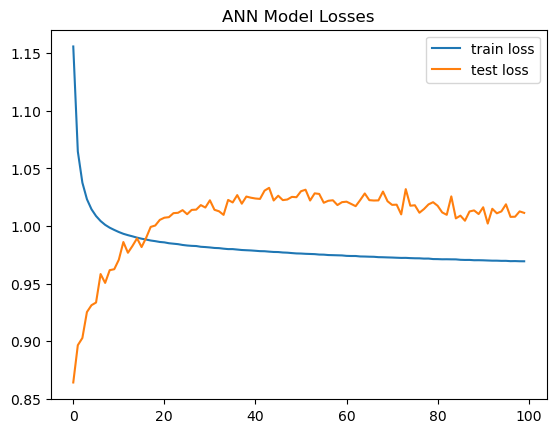

In [41]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.title("ANN Model Losses")
plt.legend();

**Again, notice how the ANN model overfits by the behaviour of the test losses.**

In [42]:
# Predict with model

Ptrain = model.predict(X_train)

Ptest = model.predict(X_test)

1/1 [==============================] - 0s 9ms/step


In [43]:
Ptrain.shape, Ptest.shape

((2231, 21), (21, 21))

In [44]:
# Grab 1st values only

Ptrain = Ptrain[:,0]

Ptest = Ptest[0]

In [45]:
# Unscale test set predictions

Ptest = scaler.inverse_transform(Ptest.reshape(-1, 1)).flatten()

In [46]:
# Save multi-output forecast to df

df.loc[test_idx, 'multioutput'] = last_train + np.cumsum(Ptest)

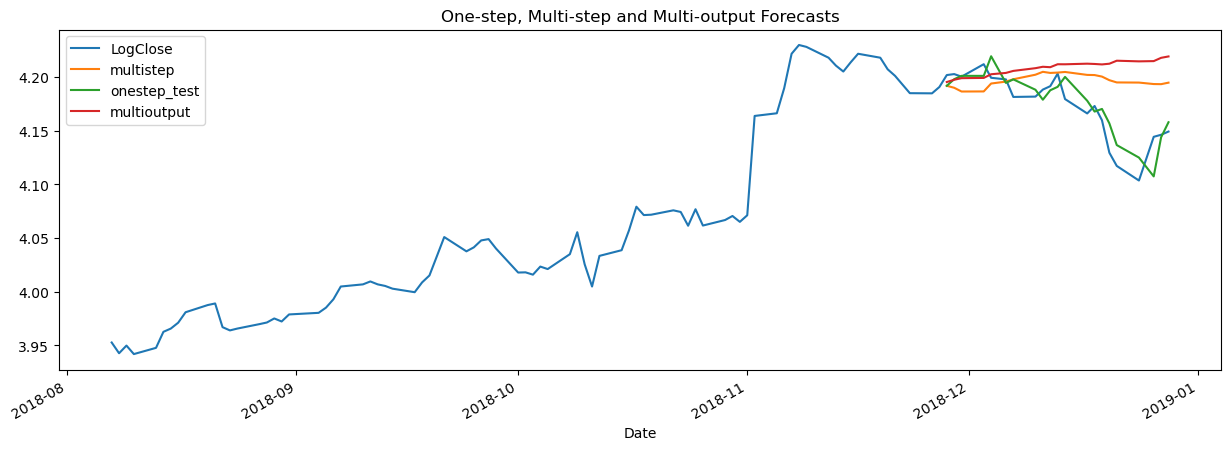

In [47]:
cols = ['LogClose', 'multistep', 'onestep_test', 'multioutput']

df.iloc[-100:][cols].plot(figsize=(15, 5))
plt.title("One-step, Multi-step and Multi-output Forecasts");

**The multi-output forecasts are the worst, straight line going off in another trend.**

In [48]:
# Compute MAPE

test_log_pass = df.iloc[-Ntest:]['LogClose']

mape1 = mean_absolute_percentage_error(test_log_pass, df.loc[test_idx, 'multistep'])
print("multi-step MAPE:", mape1)

mape2 = mean_absolute_percentage_error(test_log_pass, df.loc[test_idx, 'multioutput'])
print("multi-output MAPE:", mape2)

multi-step MAPE: 0.007412859413337911
multi-output MAPE: 0.009285685705274872


**The MAPE scores are quite small (similar to ANN for airline passengers), which is misleading. We can see that multi-output is the worst method for forecasting, but you may want to use another metric like R-Squared to measure model accuracy.**

## One-step Binary Classification

**This makes the prediction problem much simpler. You can use the same input *X* as before, but to make new target *Y* outputs, simply by assigning any value above zero to one, so any value below zero is zero.**

In [49]:
# Create new Y variable 

Ytrain_b = (y_train > 0) * 1

Ytest_b = (y_test > 0) * 1

In [50]:
# Basic ANN classification - notice it has same parameters as one-step

i = Input(shape=(T,))

x = Dense(32, activation='relu')(i)

x = Dense(1)(x)

model = Model(i, x)

In [51]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])

In [52]:
r = model.fit(X_train, 
              Ytrain_b, 
              epochs=100, 
              validation_data=(X_test, Ytest_b))

Epoch 1/100
70/70 [==============================] - 1s 3ms/step - loss: 0.7206 - accuracy: 0.4953 - val_loss: 0.7514 - val_accuracy: 0.4762
Epoch 2/100
70/70 [==============================] - 0s 2ms/step - loss: 0.7051 - accuracy: 0.4975 - val_loss: 0.7404 - val_accuracy: 0.4762
Epoch 3/100
70/70 [==============================] - 0s 2ms/step - loss: 0.6983 - accuracy: 0.4980 - val_loss: 0.7311 - val_accuracy: 0.5714
Epoch 4/100
70/70 [==============================] - 0s 2ms/step - loss: 0.6946 - accuracy: 0.4998 - val_loss: 0.7265 - val_accuracy: 0.5714
Epoch 5/100
70/70 [==============================] - 0s 2ms/step - loss: 0.6919 - accuracy: 0.5020 - val_loss: 0.7163 - val_accuracy: 0.5238
Epoch 6/100
70/70 [==============================] - 0s 2ms/step - loss: 0.6902 - accuracy: 0.5038 - val_loss: 0.7114 - val_accuracy: 0.5238
Epoch 7/100
70/70 [==============================] - 0s 2ms/step - loss: 0.6881 - accuracy: 0.5047 - val_loss: 0.7056 - val_accuracy: 0.5238
Epoch 8/100
7

Epoch 59/100
70/70 [==============================] - 0s 2ms/step - loss: 0.6602 - accuracy: 0.5379 - val_loss: 0.6823 - val_accuracy: 0.4286
Epoch 60/100
70/70 [==============================] - 0s 2ms/step - loss: 0.6596 - accuracy: 0.5446 - val_loss: 0.6766 - val_accuracy: 0.4286
Epoch 61/100
70/70 [==============================] - 0s 2ms/step - loss: 0.6593 - accuracy: 0.5455 - val_loss: 0.6817 - val_accuracy: 0.4286
Epoch 62/100
70/70 [==============================] - 0s 2ms/step - loss: 0.6586 - accuracy: 0.5450 - val_loss: 0.6822 - val_accuracy: 0.4286
Epoch 63/100
70/70 [==============================] - 0s 2ms/step - loss: 0.6584 - accuracy: 0.5442 - val_loss: 0.6727 - val_accuracy: 0.4286
Epoch 64/100
70/70 [==============================] - 0s 2ms/step - loss: 0.6583 - accuracy: 0.5450 - val_loss: 0.6743 - val_accuracy: 0.4286
Epoch 65/100
70/70 [==============================] - 0s 2ms/step - loss: 0.6572 - accuracy: 0.5424 - val_loss: 0.6790 - val_accuracy: 0.4286
Epoch 

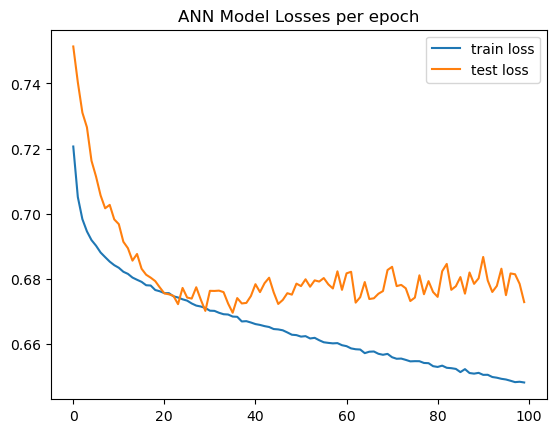

In [54]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.title("ANN Model Losses per epoch")
plt.legend();

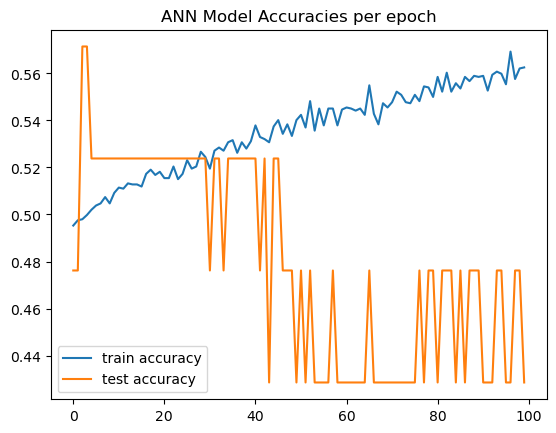

In [55]:
plt.plot(r.history['accuracy'], label='train accuracy')
plt.plot(r.history['val_accuracy'], label='test accuracy')
plt.title("ANN Model Accuracies per epoch")
plt.legend();

**Losses per epoch look OK, surprisingly, as the errors don't increase too much over time.**

**Accuracy per epoch for the test set is at least better than 50-50 choice, with some effort at predicting. But not sure if this result can be produced consistently.**

**EXERCISE:**

* **Do you think differencing is unnecessary? If so, can you prove it?**
* **Do you think logging is unnecessary? If so, can you prove it?**
* **Do you think including more past lags would be useful?**
* **Have you considered walk-forward validation to optimize hyperparameters?**
* **What is a better performance metric than accuracy for binary classification task?**